<a href="https://www.kaggle.com/code/kartikpradyumna92/housing-price-prediction?scriptVersionId=170705594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="text-align: center;">Housing price prediction</p>
Objective: Predict the house price considering the metrics such as Area, bedrooms, bathrooms, stories and other metrics

Author: Karteek Pradyumna Bulusu

In [1018]:
import pandas
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Import the dataset from Kaggle

In [1019]:
def read_input():
    df = pandas.read_csv('/kaggle/input/housing-price-prediction/Housing.csv')
    print(f"Shape of the data: {df.shape}")
    print(df.head())
    
    # return Housing data in pandas DataFrame
    return df

In [1020]:
housing_df = read_input()

Shape of the data: (545, 13)
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


# Exploratory Data Analysis
Function - eda_metrics(df)
return pandas DataFrame

<b>Description</b>: Perform basic data quality checks and describing the dataframe

In [1021]:
def eda_metrics(df):
    # check if any of the fields have null values
    print(f'Boolean value showing if a field has null values\n\n {df.isnull().any()}')
    # Returns description of the dataframe- count, mean, standard deviation, min and max values of each field in the dataframe.
    print('\n----\nDescription of the dataframe\n')
    
    # return basic statistical details like percentile, mean, std, etc
    return df.describe()
    

In [1022]:
eda_metrics(housing_df)

Boolean value showing if a field has null values

 price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad            False
guestroom           False
basement            False
hotwaterheating     False
airconditioning     False
parking             False
prefarea            False
furnishingstatus    False
dtype: bool

----
Description of the dataframe



,price,area,bedrooms,bathrooms,stories,parking
count,545.000,545.000,545.000,545.000,545.000,545.000
mean,4766729.248,5150.541,2.965,1.286,1.806,0.694
std,1870439.616,2170.141,0.738,0.502,0.867,0.862
min,1750000.000,1650.000,1.000,1.000,1.000,0.000
25%,3430000.000,3600.000,2.000,1.000,1.000,0.000
50%,4340000.000,4600.000,3.000,1.000,2.000,0.000
75%,5740000.000,6360.000,3.000,2.000,2.000,1.000
max,13300000.000,16200.000,6.000,4.000,4.000,3.000


#### Re-arranging fields

In [1023]:
housing_df['house_id'] = housing_df.index + 1
print(housing_df.columns)

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus', 'house_id'],
      dtype='object')


In [1024]:
housing_df = housing_df[[ 'house_id', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus', 'price']]

# Data Cleaning
<br>
Convert all labelled values into categorical values in order to perform correlation analysis and prediction analysis.
Only then those values will have a statistical signifance and can be used as a feature.

Convert labelled values to categorical values
Change:
Yes = 1<br>
No = 0

Create three columns - one for each of the categories part of furnishingstatus column with same name as values.

In [1025]:
def data_cleaning(df):

    df[['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']] = df[['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']].replace({'yes':1, 'no':0})
    # assigning values to each categorical value instead of creating new boolean column for each value to reduce dimension
    # Giving more weight (value = 3) from furnished and 1 to unfurnished
    df['furnishingstatus'] = df['furnishingstatus'].replace({'furnished':3, 'semi-furnished':2, 'unfurnished':1})
    
    # Return cleaned data without any categorical values.
    return df

In [1026]:
housing_df = data_cleaning(housing_df)

### Dimension
12 Features and 1 Target value
Note - Ignorning house_id from feature list since it's just an identifier.
545 rows

In [1027]:
print(housing_df.shape)
housing_df.head()

(545, 14)


,house_id,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
0,1,7420,4,2,3,1,0,0,0,1,2,1,3,13300000
1,2,8960,4,4,4,1,0,0,0,1,3,0,3,12250000
2,3,9960,3,2,2,1,0,1,0,0,2,1,2,12250000
3,4,7500,4,2,2,1,0,1,0,1,3,1,3,12215000
4,5,7420,4,1,2,1,1,1,0,1,2,0,3,11410000


# Correlation Matrix
Correlation between all the features and the Target

In [1028]:
# Removing house_id from the correlation analysis

def correlation_matrix(correlation_ip,threshold = -1.0):
    corr = correlation_ip.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    
    correlation_score = correlation_ip.corr(numeric_only=True)
    
    # return correclation matrix of the dataframe
    return correlation_score[correlation_score > threshold]

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
area,1.000,0.152,0.194,0.084,0.289,0.140,0.047,-0.009,0.222,0.353,0.235,0.171,0.536
bedrooms,0.152,1.000,0.374,0.409,-0.012,0.081,0.097,0.046,0.161,0.139,0.079,0.123,0.366
bathrooms,0.194,0.374,1.000,0.326,0.042,0.126,0.102,0.067,0.187,0.177,0.063,0.144,0.518
stories,0.084,0.409,0.326,1.000,0.122,0.044,-0.172,0.019,0.294,0.046,0.044,0.105,0.421
mainroad,0.289,-0.012,0.042,0.122,1.000,0.092,0.044,-0.012,0.105,0.204,0.200,0.157,0.297
guestroom,0.140,0.081,0.126,0.044,0.092,1.000,0.372,-0.010,0.138,0.037,0.161,0.118,0.256
basement,0.047,0.097,0.102,-0.172,0.044,0.372,1.000,0.004,0.047,0.051,0.228,0.113,0.187
hotwaterheating,-0.009,0.046,0.067,0.019,-0.012,-0.010,0.004,1.000,-0.130,0.068,-0.059,0.032,0.093
airconditioning,0.222,0.161,0.187,0.294,0.105,0.138,0.047,-0.130,1.000,0.159,0.117,0.150,0.453
parking,0.353,0.139,0.177,0.046,0.204,0.037,0.051,0.068,0.159,1.000,0.092,0.178,0.384


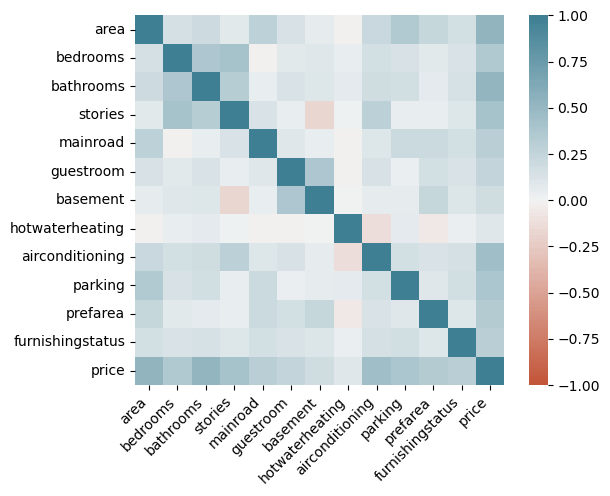

In [1029]:
correlation_ip = housing_df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
                         'hotwaterheating', 'airconditioning','parking', 'prefarea', 'furnishingstatus','price']]
correlation_matrix(correlation_ip)

**Correlation Notes**  

There is negative correlation to furnishingstatus which means Price is negatively correlated with unfurnished. That means, the price is more for furnished houses.
Price is highly correlated with Area, bathrooms, stories and bedroom which was expected.
Price of the house is most correlated to area, bathrooms, stories, bedroom in this order.

Removing `hotwaterheating` from features since correlation of that to price is very low = 0.09.

In [1030]:
housing_df_postcorr = housing_df[['house_id','area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
                          'airconditioning','parking', 'prefarea', 'furnishingstatus','price']]

---

# Variance Inflation Factor
This is to test the multicollinearity of the features (predictors)

Underdstanding the result:<br>
VIF starts at 1 and has no upper limit<br>
VIF = 1, no correlation between the independent variable and the other variables<br>
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others<br>

#### reference- https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [1031]:
# import
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1032]:
# X is features list in a pandas dataframe format
# Returns dataframe vif  with VIF score. 
def calc_vif(X):

    # Calculating VIF
    vif = pandas.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Return VIF score for each feature
    return(vif)

In [1033]:
X = housing_df_postcorr[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
                          'airconditioning','parking', 'prefarea', 'furnishingstatus']]
print(calc_vif(X))

           variables    VIF
0               area  8.373
1           bedrooms 16.268
2          bathrooms  9.468
3            stories  7.882
4           mainroad  7.144
5          guestroom  1.467
6           basement  2.027
7    airconditioning  1.703
8            parking  1.937
9           prefarea  1.482
10  furnishingstatus  7.394


### VIF First pass notes:
Bedrooms have very high VIP, but area, bedrooms, bathrooms, stories, mainroad, furnishingstatus come under high VIF.
High multicollinearity occurs between these independent variables and others. 
This means that they can be predicted by other independent variables in the dataset


                       variables    VIF
           0               area  8.373
           1           bedrooms 16.268
           2          bathrooms  9.468
           3            stories  7.882
           4           mainroad  7.144
           5          guestroom  1.467
           6           basement  2.027
           7    airconditioning  1.703
           8            parking  1.937
           9           prefarea  1.482
           10  furnishingstatus  7.394

### Removing Multicollinearity in the data
New field:
area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio = (area*furnishingstatus*mainroad)/(bedroom + bathroom + stories)

Remove area, bedrooms, bathrooms, mainroad, furnishingstatus, stories

In [1034]:
# housing_df['bedroom_to_bath_ratio'] = round(housing_df['bedrooms']/housing_df['bathrooms'],3)
housing_df_postcorr['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio'] = round(((housing_df_postcorr['area'] * housing_df_postcorr['furnishingstatus'] * (housing_df['mainroad']+1))/ (housing_df_postcorr['bedrooms']+housing_df_postcorr['bathrooms']+housing_df_postcorr['stories'])),3)
housing_df_postcorr_vif1 = housing_df_postcorr[['house_id', 'area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio', 'guestroom', 'basement',
                          'airconditioning','parking', 'prefarea', 'price']]
housing_df_postcorr_vif1.head()

,house_id,area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio,guestroom,basement,airconditioning,parking,prefarea,price
0,1,4946.667,0,0,1,2,1,13300000
1,2,4480.000,0,0,1,3,0,12250000
2,3,5691.429,0,1,0,2,1,12250000
3,4,5625.000,0,1,1,3,1,12215000
4,5,6360.000,1,1,1,2,0,11410000


### See if VIF improved

In [1035]:
X = housing_df_postcorr_vif1[['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio', 'guestroom', 'basement',
                          'airconditioning','parking', 'prefarea']]
print(calc_vif(X))

                                           variables   VIF
0  area_and_furnishingstatus_and_mainroad_to_bed_... 2.260
1                                          guestroom 1.446
2                                           basement 1.741
3                                    airconditioning 1.461
4                                            parking 1.777
5                                           prefarea 1.430


Using VIF, we unified lot of features into one and hence reduced the features list as well. 

we can use this feature list in our regression model

In [1036]:
housing_df_postcorr_vif1.head()

,house_id,area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio,guestroom,basement,airconditioning,parking,prefarea,price
0,1,4946.667,0,0,1,2,1,13300000
1,2,4480.000,0,0,1,3,0,12250000
2,3,5691.429,0,1,0,2,1,12250000
3,4,5625.000,0,1,1,3,1,12215000
4,5,6360.000,1,1,1,2,0,11410000


#### Split Features and Target

In [1037]:
# housing_df_postcorr_vif1.columns
# features = housing_df_postcorr_vif1[['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio',
#        'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea']]

# Splitting dataset to Feature and Target
features = housing_df_postcorr_vif1[['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio']] 
features = features.values.reshape(-1, 1)
target = housing_df_postcorr.price
print(f" Shape of features: {features.shape}")
print(f" Shape of target: {target.shape}")

 Shape of features: (545, 1)
 Shape of target: (545,)


In [1038]:
from sklearn.model_selection import train_test_split

### Train and Test Split
#### Function - train_test_splt(features, target)
return X_train, X_test, y_train, y_test <br>
<b>Description:</b>
Creating function to take the features and target value and split the data into train and test data and return them. <br>Creating this function also increase re-usability and flexibility while experimenting with multiple models

In [1039]:
def train_test_splt(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features,target , 
                                       random_state=104,  
                                       test_size=0.15,
                                       shuffle=True)
    
    # return Train and test data split for Feature and Target in pandas DataFrame format
    return X_train, X_test, y_train, y_test

### Function - Train_test_details(X_train, X_test, y_train, y_test)
print shape of Train and test features and Target <br>
<b>Description:</b>
Creating function to return the shape of all dataframes and to increase re-usability and flexibility while experimenting with multiple models

In [1040]:
def Train_test_details(X_train, X_test, y_train, y_test):
    print("Training feature",X_train.shape)
    print("Test feature",X_test.shape)
    print("Training target",y_train.shape)
    print("Test target",y_test.shape)

### Function - training_model(X_train, X_test, y_train, y_test, model)
returns built model <br>
<b>Description:</b>
Creating function to train the model and provide model score in order to increase re-usability and flexibility while experimenting with multiple models

In [1041]:
def training_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    # Use score method to get accuracy of model
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'Training score : {train_score}')
    print(f'Test score : {test_score}')
    
    # return the built model
    return model

### Function - predictions_phase(df, model)
returns predictions in pandas DataFrame <br>
<b>Description:</b>
Creating function to perform predcitions and return predicted values in order to increase re-usability and flexibility while experimenting with multiple models

In [1042]:
def predictions_phase(df, model):
    predictions = model.predict(df)
    
    # return the predictions in pandas DataFrame
    return predictions

### Function - prediction_dataframes(train_predictions,y_train,test_predictions, y_test)
returns two pandas dataframes: 1 with y_test and y_predictions (test_predictions); second with y_train and y_predictions (train_predictions)

<b>Description</b>: function to currate dataframe to see actual data and predictions side by side. Creating this function increases re-usability and flexibility while experimenting with multiple models

In [1043]:
def prediction_dataframes(train_predictions,y_train,test_predictions, y_test):
    final_test_predictions = [round(x,6) for x in test_predictions]
    final_train_predictions = [round(x,6) for x in train_predictions]
    
    # Dataframe for test predictions
    test_predictions_andy_test = pandas.DataFrame()
    test_predictions_andy_test['y_test'] = y_test
    test_predictions_andy_test['test_predictions'] = final_test_predictions

    # Dataframe for train predictions
    train_predictions_andy_train = pandas.DataFrame()
    train_predictions_andy_train['y_train'] = y_train
    train_predictions_andy_train['train_predictions'] = final_train_predictions
    
    # return the values in pandas DataFrame
    return test_predictions_andy_test, train_predictions_andy_train

### Function - error_analysis(target, predictions)
returns MAE, MSE and r2 score

<b>Description</b>: function to perform error analysis based on the actual data and predictions. Creating this function increases re-usability and flexibility while experimenting with multiple models

In [1044]:
def error_analysis(target, predictions):
    mae = mean_absolute_error(target, predictions)
    mse = mean_squared_error(target, predictions)
    r2 = r2_score(target, predictions)
    
    # Return error metrics
    return f'MAE : {mae};\t MSE : {mse};\t r2 : {r2}'

---

# LinearRegression on feature prepared from Variance inflation Factor process
Predicting using Linear Regression model
The data considered is feature identified from Variance inflation Factor process

In [1045]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [1046]:
Train_test_details(X_train, X_test, y_train, y_test)

Training feature (408, 1)
Test feature (137, 1)
Training target (408,)
Test target (137,)


In [1047]:
from sklearn.linear_model import LinearRegression

In [1048]:
model = LinearRegression()
LinearRegr = training_model(X_train, X_test, y_train, y_test, model)

Training score : 0.10555061561529733
Test score : 0.08033254634791953


In [1049]:
train_predictions = predictions_phase(X_train, LinearRegr)
test_predictions = predictions_phase(X_test, LinearRegr)

In [1050]:
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

In [1051]:
test_predictions_andy_test, train_predictions_andy_train = prediction_dataframes(train_predictions,y_train,test_predictions, y_test)

In [1052]:
print(f'Train data prediction score \n {error_analysis(y_train, train_predictions)}')
print(f'Test data prediction score \n {error_analysis(y_test, test_predictions)}')

Train data prediction score 
 MAE : 1338567.7245979905;	 MSE : 3000305526581.8003;	 r2 : 0.10555061561529733
Test data prediction score 
 MAE : 1394100.5501617403;	 MSE : 3566917579802.6353;	 r2 : 0.08033254634791953


#### plot train and test predictions

In [1053]:
def plot_predictions(X_train, y_train, train_predictions, X_test, y_test, test_predictions):
    plt.figure(figsize=(16, 8))

    # train data
    plt.subplot(121)
    plt.scatter(X_train, y_train)
    plt.yscale('log')
    plt.title("Train data")
    # for i, degree in enumerate(degrees):    
    plt.scatter(X_train, train_predictions, s=15)
    plt.legend(loc='upper left')

    # test data
    plt.subplot(122)
    plt.scatter(X_test, y_test)
    plt.yscale('log')
    plt.title("Test data")
    # for i, degree in enumerate(degrees):    
    plt.scatter(X_test, test_predictions)
    plt.legend(loc='upper left')

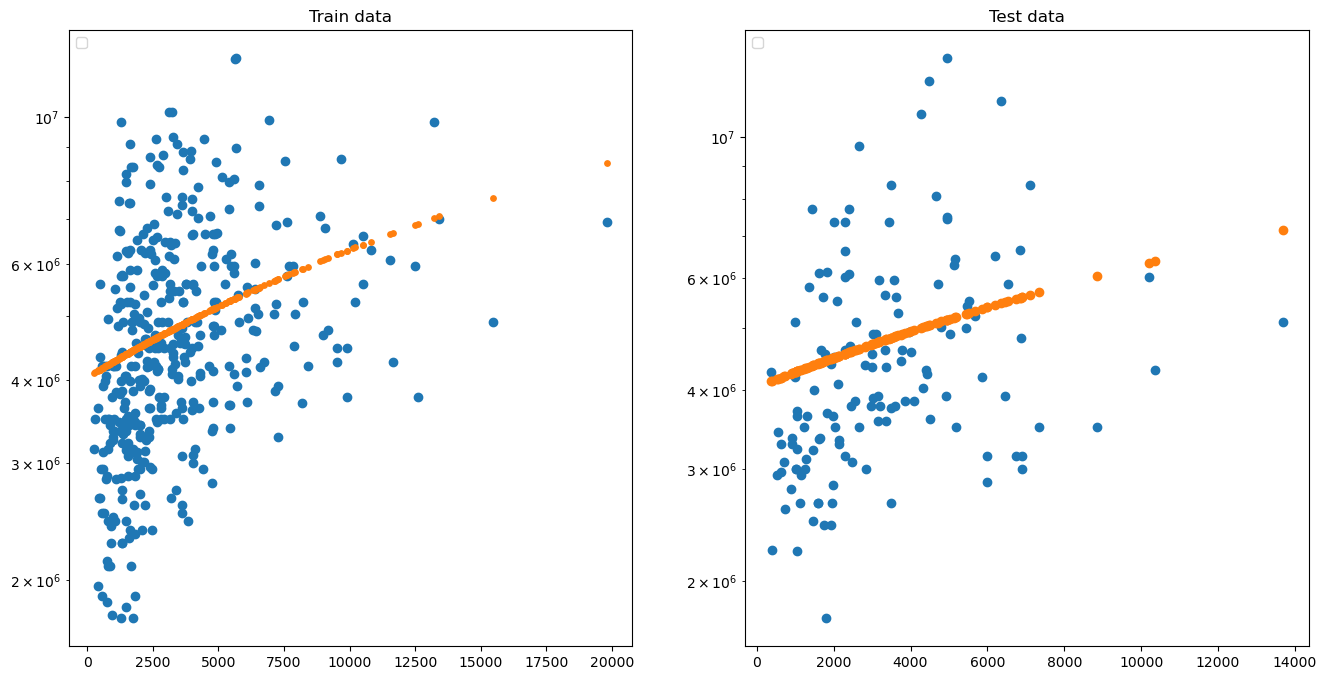

In [1054]:
plot_predictions(X_train, y_train, train_predictions, X_test, y_test, test_predictions)

### Conclusion Notes on Variance inflation Factor and LinearRegression
r2 of Training data : 0.11837052139603921<br>
r2 of Test data : 0.05242703684129213
<br>
Tried Variance Inflation Factor and unified multiple fields to reduce the correlation between the fields. The problem is identifying the appropriate way to unify multiple fields to capture the importance of multiple fields into one and drop those individual fields. 
<br>The predictions are very weak and almost neglible. This concludes that it is tough and was incorrect way to combine the features together in order to reduce the multicollinearity.

---

# MinMaxScaler
Hypothesis - Scaling down the features and target to [0.1] range will help with bias variance trade off and result in better model fit and predictions<br>
Transform the dataframe to [0,1] range

In [1055]:
from sklearn.preprocessing import MinMaxScaler

### Function - minmax_scale(df)
return scaled dataframe in pandas DataFrame format<br>

<b>Description</b>: Scaling the dataset in [0,1] range and return the scaled dataframe.

In [1056]:
def minmax_scale(df):
    df_columns = df.columns
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)

    df = pandas.DataFrame(df)
    df.columns = df_columns
    
    # return scaled data in pandas DataFrame
    return df

In [1057]:
df1 = housing_df_postcorr_vif1[['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio', 'price']]
df1.head()

,area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio,price
0,4946.667,13300000
1,4480.000,12250000
2,5691.429,12250000
3,5625.000,12215000
4,6360.000,11410000


In [1058]:
df1_scaled = minmax_scale(df1)
df1_scaled.head()

,area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio,price
0,0.239,1.000
1,0.215,0.909
2,0.277,0.909
3,0.274,0.906
4,0.312,0.836


#### Split Features and Target

In [1059]:
scaled_features = df1_scaled[['area_and_furnishingstatus_and_mainroad_to_bed_and_bath_stories_ratio']] 
scaled_features = scaled_features.values.reshape(-1, 1)
target = df1_scaled.price
print(scaled_features.shape)
print(target.shape)

(545, 1)
(545,)


#### Train and Split the scaled dataframe

In [1060]:
X_train, X_test, y_train, y_test = train_test_splt(scaled_features, target)
Train_test_details(X_train, X_test, y_train, y_test)

Training feature (463, 1)
Test feature (82, 1)
Training target (463,)
Test target (82,)


#### Re-building the model with Scaled dataframe

In [1061]:
model = LinearRegression()
LinearRegr = training_model(X_train, X_test, y_train, y_test, model)

Training score : 0.10432734033803603
Test score : 0.0681713714203418


In [1062]:
train_predictions = predictions_phase(X_train, LinearRegr)
test_predictions = predictions_phase(X_test, LinearRegr)

#### Combined prediction values dataframe

In [1063]:
test_predictions_andy_test, train_predictions_andy_train = prediction_dataframes(train_predictions,y_train,test_predictions, y_test)

#### Error analysis

In [1064]:
print(f'Train data prediction score \n {error_analysis(y_train, train_predictions)}')
print(f'Test data prediction score \n {error_analysis(y_test, test_predictions)}')

Train data prediction score 
 MAE : 0.1125309484760118;	 MSE : 0.022573955570836416;	 r2 : 0.10432734033803603
Test data prediction score 
 MAE : 0.1335978392322944;	 MSE : 0.029076236572384933;	 r2 : 0.0681713714203418


#### Plotting predictions from the scaled dataset

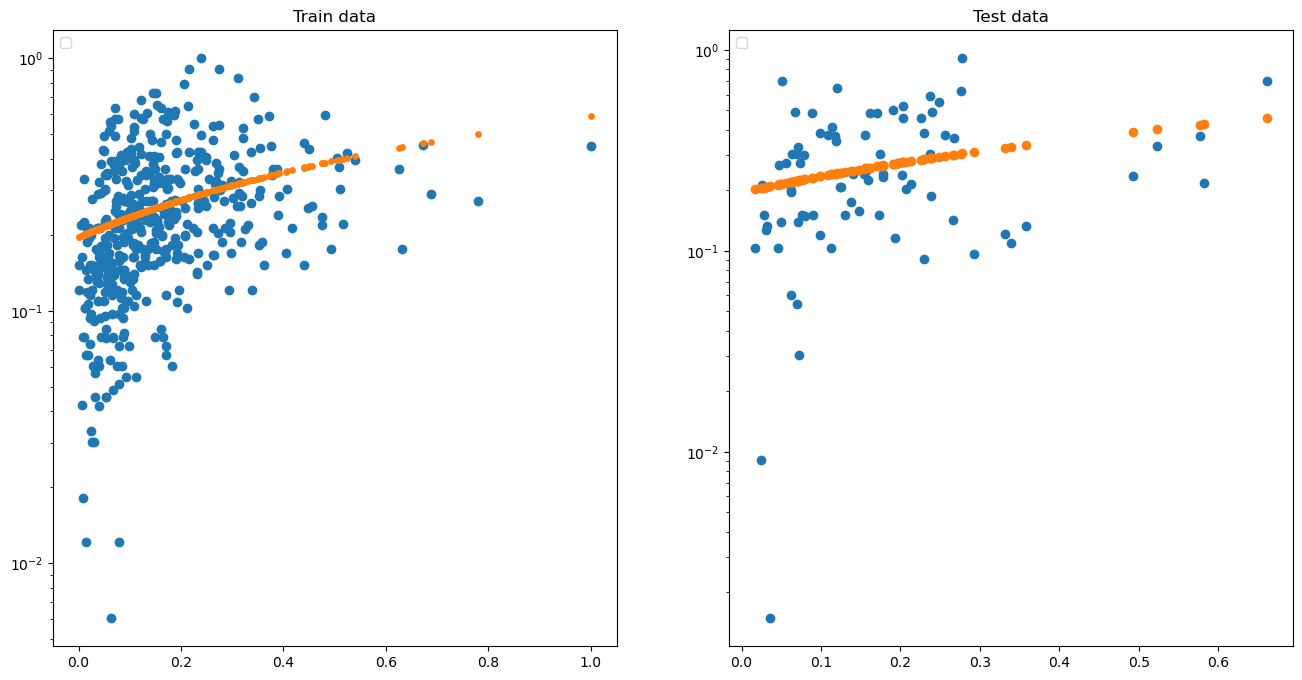

In [1065]:
plot_predictions(X_train, y_train, train_predictions, X_test, y_test, test_predictions)

### Conclusion notes on MinMaxScaler and LinearRegression

r2 of Training data : 0.10432734033803603<br>
r2 of Training data : r2 : 0.0681713714203418<br>
The MinMaxScaler also did not result in good accuracy. I did not inverse transform since the prediction were low. This hypothesis is not proved right and the experiment of using MinMaxScaler to acheive better predictions ends.

------

# Using Lasso and Ridge Regression to deal with multi variable and data with multicollinearity

Since we concluded that Linear Regression on field prepared using Variance Inflation Factor process and Linear regression on MinMaxScaler transformed data is not improving model improvement and performance, we are left with multi variable and fields which have multicollinearity.
<BR><BR>
Lasso and Ridge regression works well with multicollinearity data since they reduce the standard error by adding some bias in the estimates of the regression.<br>
In order to further improve the model fit and predictions, we are using GridSearch CV to help identify best hypermeter to use in the model    

# GridSearchCV and Lasso regression
Using GridSearchCV to identify best value for alpha (hyperparameter) for Lasso regression.<br>
Use it to build and fit the model and perform predictions.

In [1066]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold

In [1067]:
# Using all the features as provided in the original dataset
features = housing_df_postcorr[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus']]
# features = features.values.reshape(-1, 1)
target = housing_df_postcorr.price
print(f"Shape of the features: {features.shape}")
print(features.head(5))

print(f"\nShape of the Target: {target.shape}")
print(target.head(5))


Shape of the features: (545, 11)
   area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  7420         4          2        3         1          0         0   
1  8960         4          4        4         1          0         0   
2  9960         3          2        2         1          0         1   
3  7500         4          2        2         1          0         1   
4  7420         4          1        2         1          1         1   

   airconditioning  parking  prefarea  furnishingstatus  
0                1        2         1                 3  
1                1        3         0                 3  
2                0        2         1                 2  
3                1        3         1                 3  
4                1        2         0                 3  

Shape of the Target: (545,)
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


In [1068]:
params = {"alpha":np.arange(0.00001, 10, 500)}
kf=KFold(n_splits=5,shuffle=True, random_state=42)

lasso_model = linear_model.Lasso()

# GridSearchCV with model, params and folds.
lasso_gridsearch=GridSearchCV(lasso_model, param_grid=params, cv=kf)
lasso_gridsearch.fit(features, target)

print(f"Best Params for alpha is {lasso_gridsearch.best_params_['alpha']}")
best_alpha = lasso_gridsearch.best_params_['alpha']

Best Params for alpha is 1e-05


In [1069]:
# using best alpha parameter from GridSearch CV
lasso_model = linear_model.Lasso(alpha=best_alpha)

In [1070]:
X_train, X_test, y_train, y_test = train_test_splt(features, target)
lasso_model.fit(X_train, y_train)

Lasso(alpha=1e-05)

In [1071]:
print(f"Trained model score : {lasso_model.score(X_train, y_train)}")
print(f"Adjusted R squared : {1 - (1-lasso_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)}")

Trained model score : 0.6599646461720708
Adjusted R squared : 0.6516711009567555


In [1072]:
lasso_model_coef = [float(x) for x in np.abs(lasso_model.coef_)]
lasso_model_coef_array = np.asarray(clf_coef)
feature_names = features.columns.tolist()

#### Features and its estimated coefficients based on Lasso Regression

In [1073]:
coefficients_df = pandas.DataFrame()
coefficients_df['features'] = feature_names
coefficients_df['coefficients'] = lasso_model_coef
coefficients_df

,features,coefficients
0,area,236.053
1,bedrooms,145203.505
2,bathrooms,1006205.496
3,stories,419940.403
4,mainroad,409186.570
5,guestroom,318975.004
6,basement,357923.652
7,airconditioning,814540.045
8,parking,243490.438
9,prefarea,616640.754


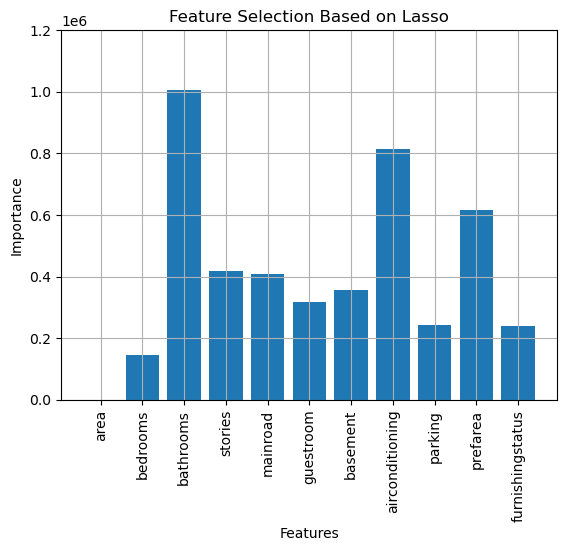

In [1074]:
# plotting the Column Names and Importance of Columns. 
plt.bar(feature_names, lasso_model_coef_array)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 1200000)
plt.show()

Feature selection<br>
Selecting features with importance > 200000

In [1075]:
# Subsetting the features which has more than 200000 importance.
feature_subset=np.array(feature_names)[clf_coef>200000]
print("Selected Feature Columns: {}".format(feature_subset))

Selected Feature Columns: ['bathrooms' 'stories' 'mainroad' 'guestroom' 'basement' 'airconditioning'
 'parking' 'prefarea' 'furnishingstatus']


In [1076]:
nf = features[feature_subset]
nf.head()

,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
0,2,3,1,0,0,1,2,1,3
1,4,4,1,0,0,1,3,0,3
2,2,2,1,0,1,0,2,1,2
3,2,2,1,0,1,1,3,1,3
4,1,2,1,1,1,1,2,0,3


#### Building and fitting the model with new set of features list

In [1077]:
X_train, X_test, y_train, y_test = train_test_splt(nf, target)

In [1078]:
lasso_model.fit(X_train, y_train)

Lasso(alpha=1e-05)

In [1079]:
print(f"Trained model score : {lasso_model.score(X_train, y_train)}")
print(f"Adjusted R squared : {1 - (1-lasso_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)}")

Trained model score : 0.5960197903638935
Adjusted R squared : 0.587993693483706


#### Notes on feature selection

Tried with multiple thresholds, the feature selection process has reduced the r2 and Adjusted r2 score for any threshold. The goal was to check if trained model accuracy increases due to the feature importance process. Since there is negative effect, we will ignore the feature selection process.

In [1080]:
# Getting the Training and the test data from original set of features
X_train, X_test, y_train, y_test = train_test_splt(features, target)

In [1081]:
# Fitting the model with new training data
lasso_model.fit(X_train, y_train)

Lasso(alpha=1e-05)

In [1082]:
print(f"Trained model score : {lasso_model.score(X_train, y_train)}")
print(f"Adjusted R squared : {1 - (1-lasso_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)}")

Trained model score : 0.6599646461720708
Adjusted R squared : 0.6516711009567555


#### Predictions using Lasso model

In [1083]:
train_predictions = predictions_phase(X_train, clf)
test_predictions = predictions_phase(X_test, clf)

In [1084]:
test_predictions_andy_test, train_predictions_andy_train = prediction_dataframes(train_predictions,y_train,test_predictions, y_test)

In [1085]:
print(f'Train data prediction score \n {error_analysis(y_train, train_predictions)}')
print(f'Test data prediction score \n {error_analysis(y_test, test_predictions)}')

Train data prediction score 
 MAE : 781456.1182553613;	 MSE : 1143263636537.243;	 r2 : 0.6599646461720708
Test data prediction score 
 MAE : 760710.2090284623;	 MSE : 1210468491205.656;	 r2 : 0.709204704581462


### Conclusion notes on GridSearch CV and Lasso Regression
r2 of Trainig data : 0.6599646461720708<br>
r2 of Test data : 0.709204704581462<br>

Lasson regression fit and predicted really well with an r2 score of 0.7092.

---

# GridSearchCV and Ridgeregression
Mimic the same process using GridSearch CV to identify best hyperparameters for the Ridge Regression model

In [1086]:
params = {"alpha":np.arange(0.00001, 0.0001, 0.001)}
kf=KFold(n_splits=5,shuffle=True, random_state=42)
Ridge_model = linear_model.Ridge()

# GridSearchCV with model, params and folds.
Ridge_gridsearch=GridSearchCV(Ridge_model, param_grid=params, cv=kf)
Ridge_gridsearch.fit(features, target)
print(f"Best Params for alpha is {Ridge_gridsearch.best_params_['alpha']}")

best_alpha = Ridge_gridsearch.best_params_['alpha']

Best Params for alpha is 1e-05


In [1087]:
# using the best value for alpha based on GridSearch
ridge_model = linear_model.Ridge(alpha=best_alpha)

In [1088]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=1e-05)

#### Features and its estimated coefficients based on Ridge Regression

In [1089]:
coefficients_df = pandas.DataFrame()
coefficients_df['features'] = features.columns.tolist()
coefficients_df['coefficients'] = [float(x) for x in np.abs(ridge_model.coef_)]
coefficients_df

,features,coefficients
0,area,236.053
1,bedrooms,145203.520
2,bathrooms,1006205.395
3,stories,419940.419
4,mainroad,409186.493
5,guestroom,318974.987
6,basement,357923.650
7,airconditioning,814539.969
8,parking,243490.444
9,prefarea,616640.688


In [1090]:
print(f"Ridge regression Trained model score : {ridge_model.score(X_train, y_train)}")
print(f"Adjusted R squared : {1 - (1-ridge_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)}")

Ridge regression Trained model score : 0.6599646461720694
Adjusted R squared : 0.651671100956754


Predictions using Ridge model

In [1091]:
train_predictions = predictions_phase(X_train, ridge_model)
test_predictions = predictions_phase(X_test, ridge_model)

In [1092]:
test_predictions_andy_test, train_predictions_andy_train = prediction_dataframes(train_predictions,y_train,test_predictions, y_test)

In [1093]:
print(f'Train data prediction score \n {error_analysis(y_train, train_predictions)}')
print(f'Test data prediction score \n {error_analysis(y_test, test_predictions)}')

Train data prediction score 
 MAE : 781456.1108684249;	 MSE : 1143263636537.2478;	 r2 : 0.6599646461720694
Test data prediction score 
 MAE : 760710.2113509374;	 MSE : 1210468492619.2065;	 r2 : 0.7092047042418796


#### Conclusion notes on GridSearch CV and Ridge Regression
r2 of Trainig data : 0.6599646461720694<br>
r2 of Test data : 0.7092047042418796<br>

Ridge regression fit and predicted really well with an r2 score of 0.7092.

-----------

# <b>Conclusion Notes</b>
House Price prediction data is multi variable and suffers with multicollinearity. <BR>
We tried removing multicollinearity using Variance Inflation Factor (VIF) but it has it's own challenges. The problem is identifying the appropriate way to unify multiple fields to capture the importance of multiple fields into one and drop those individual fields. We got a weak prediction using this method <br>
Rescaling using MinMaxScaler on VIF data also did not result in good predictions. <br>
This concluded our attempt to reduce dimension to avoid multicollinearity and fit into LinearRegression.<br>
We used Lasso and Ridge regression since they handle multi variable data well and also deals with multicollinearity really well.<br>
In addition, I used GridSearch CV to identify best hyperparameter to use to build, fit and predict using the model.<br>
This has improved the accuracy, achieved r2 score = 0.7092047042418796 on the test data.
